<a href="https://colab.research.google.com/github/ahmadhajmosa/Machine-learning-labs/blob/daniel.frumlacher/Machine_Translation_with_Seq2Seq_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Translation with Seq2Seq model



# sequence to sequence model


![alt text](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2019/01/enc_dec_2.png)

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


# Read the Data into our IDE


In [0]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [0]:
# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [0]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)
#mport urllib.request as urllib2

#data = urllib2.urlopen('https://raw.githubusercontent.com/Apress/applied-natural-language-processing-w-python/master/data_etc/deu.txt')



deu_eng = deu_eng[:50000,:]


In [5]:
data[0]

'H'

In [0]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng=deu_eng[0:1000,:]

In [0]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})




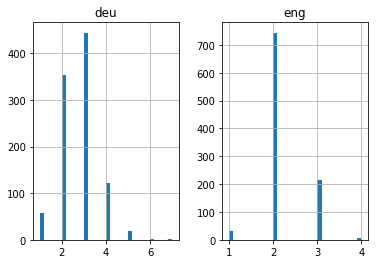

In [24]:
length_df.hist(bins = 30)
plt.show()

In [0]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [26]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 381


In [27]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)


Deutch Vocabulary Size: 689


In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [0]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [0]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Embedding, LSTM, RepeatVector, Dense

# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [0]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [0]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [34]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Train on 640 samples, validate on 160 samples
Epoch 1/30
640/640 [==============================] - 6s 9ms/step - loss: 5.9223 - val_loss: 4.5695

Epoch 00001: val_loss improved from inf to 4.56953, saving model to model.h1.24_jan_19
Epoch 2/30
640/640 [==============================] - 3s 5ms/step - loss: 3.9623 - val_loss: 2.0218

Epoch 00002: val_loss improved from 4.56953 to 2.02175, saving model to model.h1.24_jan_19
Epoch 3/30
640/640 [==============================] - 4s 6ms/step - loss: 1.8855 - val_loss: 1.8642

Epoch 00003: val_loss improved from 2.02175 to 1.86421, saving model to model.h1.24_jan_19
Epoch 4/30
640/640 [==============================] - 4s 6ms/step - loss: 1.7459 - val_loss: 1.7897

Epoch 00004: val_loss improved from 1.86421 to 1.78970, saving model to model.h1.24_jan_19
Epoch 5/30
640/640 [==============================] - 4s 6ms/step - loss: 1.6600 - val_loss: 1.7386

Epoch 00005: val_loss improved from 1.78970 to 1.73857, saving model to model.h1.24_jan_1

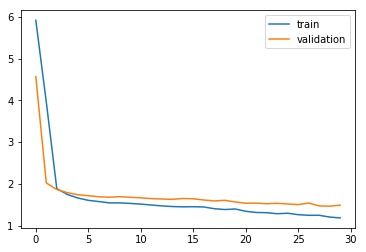

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()


In [0]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [0]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [0]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [39]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})
# print 15 rows randomly
pred_df.sample(15)

,actual,predicted
64,Come again,get
20,He is here,i it
158,Go to bed,i
48,Try it,go
121,Beat it,get away
134,You run,get
118,Get away,get
133,I found it,i
147,I am sure,i it
11,Tom lies,tom


model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))